In [1]:
from qepy import *
from yambopy import *
from qepy import PwIn
import matplotlib.pyplot as plt
import numpy as np
#import json
import Routines as R

# Convergence analysis of the self-consistent QE computation

We study the convergence of the self-consistent computation for the determination of the ground state density. The relevant convergence parameteres are the number of k-points and the cutoff on the plane wave expansion

In [2]:
reload(R)
scf_kpoints = [2,3,4,5,6]
scf_ecut = [10,15,20,25,30]
scfDict = R.buildScf(scf_kpoints,scf_ecut)

In [3]:
R.runScf(scfDict,8,True)

skip the computation for : scf/output/k2_ecut10.log
skip the computation for : scf/output/k2_ecut15.log
skip the computation for : scf/output/k2_ecut20.log
skip the computation for : scf/output/k2_ecut25.log
skip the computation for : scf/output/k2_ecut30.log
skip the computation for : scf/output/k3_ecut10.log
skip the computation for : scf/output/k3_ecut15.log
skip the computation for : scf/output/k3_ecut20.log
skip the computation for : scf/output/k3_ecut25.log
skip the computation for : scf/output/k3_ecut30.log
skip the computation for : scf/output/k4_ecut10.log
skip the computation for : scf/output/k4_ecut15.log
skip the computation for : scf/output/k4_ecut20.log
skip the computation for : scf/output/k4_ecut25.log
skip the computation for : scf/output/k4_ecut30.log
skip the computation for : scf/output/k5_ecut10.log
skip the computation for : scf/output/k5_ecut15.log
skip the computation for : scf/output/k5_ecut20.log
skip the computation for : scf/output/k5_ecut25.log
skip the com

In [4]:
# add the energy field to scfDict
for k in scfDict:
    for e in scfDict[k]:
        scfDict[k][e]['energy'] = R.get_totalEnergy(scfDict[k][e]['outputFile'])

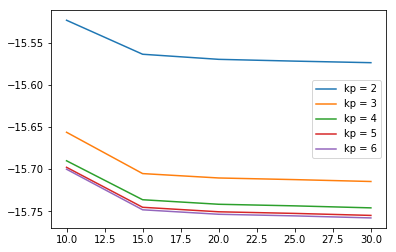

In [5]:
# plot the total energy in function of the ecut for each choice of kpoints
for k in scf_kpoints:
    energy = []
    for e in scf_ecut:
        energy.append(scfDict[k][e]['energy'])
    plt.plot(scf_ecut,energy,label= 'kp = '+str(k))
plt.legend()
plt.show()
    

We choose kpoints = 6 and ecut = 30 as convergence parameters of the scf computation

In [6]:
scf_kconv = 6
scf_ecutconv = 30

## QE nscf simulations

We perform a bunch of nscf simulations starting from the results of the scf one with converged parameters.

Nscf simulations are performed parametrically in terms of the quantities:

* nscf_kpoints
* nscf_ecut
* nscf_nbnds

In [7]:
nscf_kpoints = [2,4,6,8]
nscf_nbnds = [12]
nscf_ecut = [scf_ecutconv] 
#seems to give problems if different (or lower?) of the scf_ecutconv. 
#sems that P2y don't work if nscf_ecut is different from scf_ecutconv

In [8]:
reload(R)
nscfDict = R.buildNscf(nscf_kpoints,nscf_ecut,nscf_nbnds,scf_kconv,scf_ecutconv)

In [9]:
nscfDict

{2: {30: {12: {'inputFile': 'nscf/input/k2_ecut30_nbnd12.nscf',
    'outFolder': 'nscf/output/k2_ecut30_nb12.save',
    'outputFile': 'nscf/output/k2_ecut30_nbnd12.log'}}},
 4: {30: {12: {'inputFile': 'nscf/input/k4_ecut30_nbnd12.nscf',
    'outFolder': 'nscf/output/k4_ecut30_nb12.save',
    'outputFile': 'nscf/output/k4_ecut30_nbnd12.log'}}},
 6: {30: {12: {'inputFile': 'nscf/input/k6_ecut30_nbnd12.nscf',
    'outFolder': 'nscf/output/k6_ecut30_nb12.save',
    'outputFile': 'nscf/output/k6_ecut30_nbnd12.log'}}},
 8: {30: {12: {'inputFile': 'nscf/input/k8_ecut30_nbnd12.nscf',
    'outFolder': 'nscf/output/k8_ecut30_nb12.save',
    'outputFile': 'nscf/output/k8_ecut30_nbnd12.log'}}}}

In [10]:
R.runNscf(nscfDict,8,True)

skip the computation for : nscf/output/k2_ecut30_nbnd12.log
skip the computation for : nscf/output/k4_ecut30_nbnd12.log
skip the computation for : nscf/output/k6_ecut30_nbnd12.log
skip the computation for : nscf/output/k8_ecut30_nbnd12.log


Prepare the system for the yambo computation. Run p2y and yambo (without options) in all the .save folders
generated by the nscf simulations

In [11]:
R.runP2y(nscfDict)

execute : cd nscf/output/k2_ecut30_nb12.save;p2y;yambo
execute : cd nscf/output/k4_ecut30_nb12.save;p2y;yambo
execute : cd nscf/output/k6_ecut30_nb12.save;p2y;yambo
execute : cd nscf/output/k8_ecut30_nb12.save;p2y;yambo


## Convergence analysis of various approximations for the self energy

Create the high-level yambo folder. For each choice of the nscf parameters create a folder with the name kp_#k_ecut#e_nb#nbnds and the copy the corresponding SAVE directory in the associated folder and perform a nscf QE computation in this folder. 

Structure of the yambo dictionary:

yambo[k_nscf][ecut_nscf][nbnds] = {}

This dictionary has a key 'folder' that identifies the folder in which the subsequent yambo
computations are performed and a set of keys like 'hf', 'cosex',.... that contains a further dictionaries with the parameters and results of the different levels of yambo computations 

In [12]:
reload(R)
yamboDic = R.buildYambo(nscfDict)
#yamboDic

### HF approximation of $\Sigma$

Perform a (bunch of) HF computation for each choice of the nscf parameters.
HF computations performed in function of the parameters

In [13]:
# modify the name in G0_Gcomp
EXXRLvcs = [500,1000,1500,2000,2500]  #mHa

Build the input file and prepare yamboDic

In [14]:
reload(R)
R.buildHF(yamboDic,EXXRLvcs)
#yamboDic

In [15]:
# run the HF simulations
R.runHF(yamboDic,8,True)
#yamboDic

skip the computation for : yambo/k2_ecut30_nb12/hf_exRL1000/o-hf_exRL1000.hf
skip the computation for : yambo/k2_ecut30_nb12/hf_exRL1500/o-hf_exRL1500.hf
skip the computation for : yambo/k2_ecut30_nb12/hf_exRL500/o-hf_exRL500.hf
skip the computation for : yambo/k2_ecut30_nb12/hf_exRL2000/o-hf_exRL2000.hf
skip the computation for : yambo/k2_ecut30_nb12/hf_exRL2500/o-hf_exRL2500.hf
skip the computation for : yambo/k4_ecut30_nb12/hf_exRL1000/o-hf_exRL1000.hf
skip the computation for : yambo/k4_ecut30_nb12/hf_exRL1500/o-hf_exRL1500.hf
skip the computation for : yambo/k4_ecut30_nb12/hf_exRL500/o-hf_exRL500.hf
skip the computation for : yambo/k4_ecut30_nb12/hf_exRL2000/o-hf_exRL2000.hf
skip the computation for : yambo/k4_ecut30_nb12/hf_exRL2500/o-hf_exRL2500.hf
skip the computation for : yambo/k6_ecut30_nb12/hf_exRL1000/o-hf_exRL1000.hf
skip the computation for : yambo/k6_ecut30_nb12/hf_exRL1500/o-hf_exRL1500.hf
skip the computation for : yambo/k6_ecut30_nb12/hf_exRL500/o-hf_exRL500.hf
skip 

In [16]:
# reads the results
R.getHFresults(yamboDic)

read file : yambo/k8_ecut30_nb12/hf_exRL1000/o-hf_exRL1000.hf
read file : yambo/k8_ecut30_nb12/hf_exRL1500/o-hf_exRL1500.hf
read file : yambo/k8_ecut30_nb12/hf_exRL500/o-hf_exRL500.hf
read file : yambo/k8_ecut30_nb12/hf_exRL2000/o-hf_exRL2000.hf
read file : yambo/k8_ecut30_nb12/hf_exRL2500/o-hf_exRL2500.hf
read file : yambo/k2_ecut30_nb12/hf_exRL1000/o-hf_exRL1000.hf
read file : yambo/k2_ecut30_nb12/hf_exRL1500/o-hf_exRL1500.hf
read file : yambo/k2_ecut30_nb12/hf_exRL500/o-hf_exRL500.hf
read file : yambo/k2_ecut30_nb12/hf_exRL2000/o-hf_exRL2000.hf
read file : yambo/k2_ecut30_nb12/hf_exRL2500/o-hf_exRL2500.hf
read file : yambo/k4_ecut30_nb12/hf_exRL1000/o-hf_exRL1000.hf
read file : yambo/k4_ecut30_nb12/hf_exRL1500/o-hf_exRL1500.hf
read file : yambo/k4_ecut30_nb12/hf_exRL500/o-hf_exRL500.hf
read file : yambo/k4_ecut30_nb12/hf_exRL2000/o-hf_exRL2000.hf
read file : yambo/k4_ecut30_nb12/hf_exRL2500/o-hf_exRL2500.hf
read file : yambo/k6_ecut30_nb12/hf_exRL1000/o-hf_exRL1000.hf
read file : ya

Analysis of the convergence of $\frac{EHF-E0}{E0}$ in function of the number of nscf_kpoints. Uses the first (and actually the only) value of the parameters nscf_nbnds and nscf_ecut

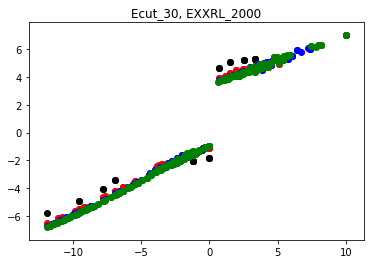

In [17]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]
ecut = nscf_ecut[0]
exRL = EXXRLvcs[3]

colors = ['black','red','blue','green']
for ind,k in enumerate(kp):
    y = yamboDic[k][ecut][nb]['hf'][exRL]
    BND = y['BND']
    E0 = y['E0']
    EHF = y['EHF']
    for bnd,e0,ehf in zip(BND,E0,EHF):
        if bnd < 8: #plot points of the first 8 band
            plt.scatter(e0,ehf-e0,c = colors[ind])
plt.title('Ecut_'+str(ecut)+', EXXRL_'+str(exRL))
plt.show()

Analysis of the convergence of the gap (both direct and indirect)

{1000: [9.485406, 8.067242, 7.802669999999999, 7.753550000000001], 1500: [9.645052, 8.223525, 7.956619999999999, 7.907760000000001], 500: [8.777731, 7.575824, 7.31935, 7.24456], 2000: [9.645052, 8.223525, 7.956619999999999, 7.907760000000001], 2500: [9.644817, 8.230665, 7.96211, 7.9092899999999995]}


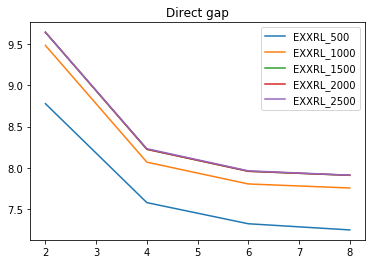

In [18]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]
ecut = nscf_ecut[0]

dirGap = {}
for exRL in EXXRLvcs:
    dirGap[exRL] = []
    for k in kp:
        y = yamboDic[k][ecut][nb]['hf'][exRL]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == 1.0 and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y['EHF'][ind]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == 1.0 and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y['EHF'][ind]
        dirGap[exRL].append(ELumo-EHomo)

    plt.plot(kp,dirGap[exRL],label= 'EXXRL_'+str(exRL))

print dirGap
plt.title('Direct gap')
plt.legend()
plt.show()

{1000: [7.008995, 5.546253, 5.255940000000001, 5.2013], 1500: [7.236225, 5.798093, 5.508369999999999, 5.45594], 500: [5.9684349999999995, 4.6912720000000006, 4.41859, 4.355919999999999], 2000: [7.236225, 5.798093, 5.508369999999999, 5.45594], 2500: [7.30334, 5.876089, 5.58709, 5.53428]}


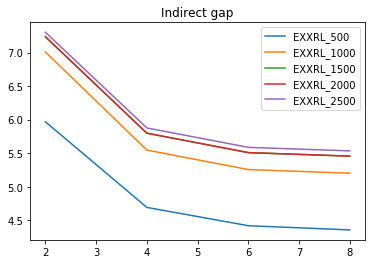

In [19]:
kp = yamboDic.keys()
kp.sort()
nb = nscf_nbnds[0]
ecut = nscf_ecut[0]

# stucture for indirect gap [k] : [khomo,klumo]
# using indGap as difference between homo in Gamma(0,0,0) 
# and lumo in (0.0, -0.5, -0.5) (rlu)
par = {2:[1,3], 4:[1,7], 6:[1,13], 8:[1,21]}

indirGap = {}
for exRL in EXXRLvcs:
    indirGap[exRL] = []
    for k in kp:
        y = yamboDic[k][ecut][nb]['hf'][exRL]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == par[k][0] and bndVal == 4.0:
                break
            else:
                ind +=1
        EHomo = y['EHF'][ind]
        ind = 0
        for kVal,bndVal in zip(y['KP'],y['BND']):
            if kVal == par[k][1] and bndVal == 5.0:
                break
            else:
                ind +=1
        ELumo = y['EHF'][ind]
        indirGap[exRL].append(ELumo-EHomo)

    plt.plot(kp,indirGap[exRL],label= 'EXXRL_'+str(exRL))

print indirGap
plt.title('Indirect gap')
plt.legend()
plt.show()

This plots conclude the convergence analysis of the HF approximation of the self-energy. 

### COHSEX approximation of $\Sigma$

As a first step work in the approximation "without empty "bands". So we do not add the contribution of conduction bands for the evaluation of the Green function.
The evaluation of $W$ passes through:
$$
\chi = \chi_0 + \chi_0(v_H+f_{xc})\chi \\
W = v+v\chi v
$$
In the COHSEX one considers only the static contribution of the response $\chi(\omega=0)$ and we also limit our analysis to the Hartree kernel, so that $f_{xc}=0$ (RPA approximations?).

Relevant parameters for the convergence:
* k-points as for the HF case. Perform a bunch of simulation in the various folder built after the nscf 
calculations
* energy cutoff of the plane wave expansion. In this case the parameter is NGsBlkXs. It has the same meaning of EXXRLvcs in the HF case?
* number of empty bands for the construction of $\chi_0$

In [60]:
W_Gcomp = [500,1000,1500] #[500,1000,1500,2000,2500]  #mHa
W_nbnds = [10,20]

In [61]:
def buildCOHSEXinput(fold,fname,wg,wn):
    #-b static inverse dielectric matrix
    #-k kernel type: hartree
    #-g Dyson Equation solver (n)ewton
    #-p GW approximations (c)OHSEX
    # yambo -b -k hartree -g n -p c
    y = YamboIn('yambo -b -k hartee -g n -p c -V All',folder=fold)
    y['NGsBlkXs'] = [wg,'mHa']
    wnInp = [1,wn]
    y['BndsRnXs'] = wnInp
    y.write(fold+'/'+fname)

def buildCOHSEX(ydic,wgcomp,wnbnds):
    """
    Build the input file for a yambo COHSEX computation and update the yambo dictionary
    with the paramters of the choosen computations. The keys of the ['cs'] dictionary
    are tuple of the form (W_Gcomp,W_nbnds)
    """
    kpoints = ydic.keys()
    for k in kpoints:
        ecuts = ydic[k].keys()
        for e in ecuts:
            nb = ydic[k][e].keys()
            for n in nb:
                ydic[k][e][n]['cs'] = {}
                for wg in wgcomp:
                    for wn in wnbnds:    
                        jobname = 'cs_WGcomp'+str(wg)+'_wNbn'+str(wn)
                        inpfile = 'cs_WGcomp'+str(wg)+'_wNbn'+str(wn)+'.in'
                        outfile = 'o-cs_WGcomp'+str(wg)+'_wNbn'+str(wn)+'.cs'
                        buildCOHSEXinput(ydic[k][e][n]['folder'],inpfile,wg,wn)
                        ydic[k][e][n]['cs'][(wg,wn)]= {'inputFile':inpfile,
                        'jobName':jobname,
                        'outputFile':ydic[k][e][n]['folder']+'/'+jobname+'/'+outfile}

In [62]:
buildCOHSEX(yamboDic,W_Gcomp,W_nbnds)

In [64]:
yamboDic[2][30][12]['cs'][500,10]

{'inputFile': 'cs_WGcomp500_wNbn10.in',
 'jobName': 'cs_WGcomp500_wNbn10',
 'outputFile': 'yambo/k2_ecut30_nb12/cs_WGcomp500_wNbn10/o-cs_WGcomp500_wNbn10.cs'}

In [ ]:
#########################################################################à

In [170]:
#use yambopy tool to generate json file for data analysis
pack_files_in_folder('HF/k2_ecut30_nb20')

HF/k2_ecut30_nb20/hf_7


In [171]:
# We can also directly read the .json file as a python dictionary
%cd 'HF/k2_ecut30_nb20'
with open('hf_7.json') as f:
    results = json.load(f)
%cd ../../

/home/marco/Data/RICERCA/MANY BODY/Yambo-nb/Si-equilibrium/GW convergence analysis/HF/k2_ecut30_nb20
/home/marco/Data/RICERCA/MANY BODY/Yambo-nb/Si-equilibrium/GW convergence analysis


In [174]:
results

{u'alat': [5.150000095367432, 5.150000095367432, 5.150000095367432],
 u'atompos': [[-1.287500023841858, 1.287500023841858, 1.287500023841858]],
 u'atomtype': [14.0],
 u'data': {},
 u'inputfile': {},
 u'kpts_iku': [[0.0, 0.0, 0.0],
  [0.25, -0.25, 0.25],
  [0.0, -0.5, 0.0],
  [0.25, -0.25, -0.25]],
 u'lattice': [[-5.150000095367432, 0.0, 5.150000095367432],
  [0.0, 5.150000095367432, 5.150000095367432],
  [-5.150000095367432, 5.150000095367432, 0.0]],
 u'runtime': {u'r-hf_7_HF_and_locXC': {u'[04.01] HF occupations report': [u'Overview']}},
 u'sym_car': [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],
  [[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, -1.0]],
  [[0.0, 0.0, 1.0], [0.0, -1.0, 0.0], [1.0, 0.0, 0.0]],
  [[-1.0, 0.0, 0.0], [0.0, 0.0, -1.0], [0.0, -1.0, 0.0]],
  [[0.0, 0.0, -1.0], [-1.0, 0.0, 0.0], [0.0, 1.0, 0.0]],
  [[0.0, -1.0, 0.0], [0.0, 0.0, 1.0], [-1.0, 0.0, 0.0]],
  [[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]],
  [[0.0, -1.0, 0.0], [-1.0, 0.0, 0.0], [0.0, 0